In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Exercise 5: Simple Hay et al. model neuron simulation with one synaptic input

In this exercise you will work with a 'state-of-the-art' multi-compartmental model form literature, namely the Hay model (Hay et al. (2011) PLoS Comput Biol 7: e1002107, doi:10.1371/journal.pcbi.1002107). This model has an anatomically reconstructed dendritic morphology (Figure 1), and many active conductances that have been added and fitted to experimental data. Many such cell models are now freely available from online data bases like ModelDB (https://senselab.med.yale.edu/modeldb/), and if you want to make your own model, dendritic morphologies can be downloaded from NeuroMorpho.org (https://neuromorpho.org). Scientific papers based solely on simulations with such cell models taken from literature and data bases are common. 

In this exercise you will work with this simple jupyter-notebook utilizing LFPy and Neuron, that you can adapt to solve this exercise.

<img src="Hay-neuron.png" width = "160">

Figure 1: Reconstructed morphology of a rat neocortical pyramidal cell by Hay et al. (2011). Experimental recording sites are indicated by schematic electrodes at the soma (black), proximal apical dendrite (400 $\mu$m from the soma, blue) and distal apical site (620 $\mu$m from the soma, red). Taken from Figure 1 in Hay et al. (2011),
http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002107

__(i)__ Make the cell spike by giving it one or more synaptic inputs. Experiment with different synapse numbers, locations and synaptic strengths. Have fun! 

__(ii)__ Plot the 'raw' and normalized subthreshold somatic voltage response from synaptic inputs for increasing distances between the synaptic input and the soma. Can you describe what you see?

__(iii)__ Plot the somatic membrane potential response to a spike train input to a synapse in the distal apical dendrite when the neuron is passive, that is, has no active conductances. The incoming spike train should contain three spikes, with an even interspike interval of 40 ms. How do the synaptic input sum at the input site? How do they sum in the soma compartment? How does it change if the cell has all the original active conductances? (Note that the documentation in the code explains how to turn active conductances on and off.)

__(iv)__ [Optional] In the release of the LFPy program (Linden et al. (2014). Frontiers in Neuroinformatics 7:41 (2014), doi: 10.3389/fninf.2013.00041), several example jupyter notebooks were included. They are available through the LFPy GitHub pages at https://github.com/LFPy/LFPy.git. Test out some of them (but note that the example notebooks also produce plots of extracellular potentials which we will go through later in the course).
The simplest way to get all example files is cloning LFPy using git:

    git clone https://github.com/LFPy/LFPy.git  # clone sources
    cd LFPy/examples  # enter examples directory
    jupyter-notebook  # start jupyter-notebook in the browser

In [2]:
import os
from os.path import join
import numpy as np
import neuron
import LFPy
from hay_model.hay_active_declarations import active_declarations
nrn = neuron.h

In [3]:
# the following will attempt to convert NEURON NMODL (.mod) files into C-language files and 
# compile them. This step requires the correct C-compiler, which may depend on your system and 
# python (conda) environment and the manner in which NEURON and LFPy was installed. 
# 
# If you encounter errors, contact the tutor(s) for some technical assistance. 
retval = os.getcwd()
print("Current working directory %s" % retval)
os.chdir(os.path.join("hay_model", "mod"))
!nrnivmodl
os.chdir(retval)

Current working directory /Users/ehagen/WorkNMBU/FYS388_2020/Exercises_Fys388_2019/Exercise05
/usr/bin/xcrun
/Users/ehagen/WorkNMBU/FYS388_2020/Exercises_Fys388_2019/Exercise05/hay_model/mod
CaDynamics_E2.mod Ca_HVA.mod Ca_LVAst.mod Ih.mod Im.mod K_Pst.mod K_Tst.mod NaTa_t.mod NaTs2_t.mod Nap_Et2.mod SK_E2.mod SKv3_1.mod
CaDynamics_E2.mod Ca_HVA.mod Ca_LVAst.mod Ih.mod Im.mod K_Pst.mod K_Tst.mod NaTa_t.mod NaTs2_t.mod Nap_Et2.mod SK_E2.mod SKv3_1.mod
 -> Compiling mod_func.c
gcc -O2   -I. -I..   -I/Users/ehagen/anaconda3/envs/fys388_pip/lib/python3.8/site-packages/neuron/.data/include  -I/usr/local/Cellar/open-mpi/4.0.4_1/include -fPIC -c mod_func.c -o mod_func.o
 -> NMODL CaDynamics_E2.mod
 -> NMODL Ca_HVA.mod
MODLUNIT=/Users/ehagen/anaconda3/envs/fys388_pip/lib/python3.8/site-packages/neuron/.data/share/nrn/lib/nrnunits.lib \
	  /Users/ehagen/anaconda3/envs/fys388_pip/lib/python3.8/site-packages/neuron/.data/bin/nocmodl Ca_HVA.mod
 -> NMODL Ca_LVAst.mod
MODLUNIT=/Users/ehagen/anacond

(cd .. ; rm -f x86_64/.libs/libnrnmech.so ; mkdir -p x86_64/.libs ; ln -s ../../x86_64/libnrnmech.dylib x86_64/.libs/libnrnmech.so)
Successfully created x86_64/special


In [4]:
def return_cell(synaptic_y_pos=900, 
                conductance_type='active', 
                weight=0.001, 
                input_spike_train=np.array([10.])):
    """
    Runs a NEURON simulation and returns an LFPy cell object for a single synaptic input.
    
    :param synaptic_y_pos: position along the apical dendrite where the synapse is inserted.
    :param conductance_type: Either 'active' or 'passive'. If 'active' all original ion-channels are included,
           if 'passive' they are all removed, yielding a passive cell model.
    :param weight: Strength of synaptic input.
    :param input_spike_train: Numpy array containing synaptic spike times
    :return: cell object where cell.imem gives transmembrane currents, cell.vmem gives membrane potentials.
             See LFPy documentation for more details and examples.
    """
    nrn('forall delete_section()')
    model_path = join('hay_model')
    neuron.load_mechanisms(join(model_path, 'mod'))
    cell_parameters = {
        'morphology': join(model_path, 'cell1.hoc'),
        'v_init': -65,
        'passive': False,
        'nsegs_method': 'lambda_f',
        'lambda_f': 100,
        'dt': 2**-3,  # Should be a power of 2
        'tstart': -200,
        'tstop': 200,
        'custom_code': [join(model_path, 'custom_codes.hoc')],
        'custom_fun': [active_declarations],
        'custom_fun_args': [{'conductance_type': conductance_type}],
    }
    cell = LFPy.Cell(**cell_parameters)
    synapse_parameters = {
        'idx': cell.get_closest_idx(x=0., y=synaptic_y_pos, z=0.),
        'e': 0.,
        'syntype': 'ExpSyn',
        'tau': 10.,
        'weight': weight,
        'record_current': True,
    }
    synapse = LFPy.Synapse(cell, **synapse_parameters)
    synapse.set_spike_times(input_spike_train)
    cell.simulate(rec_imem=True, rec_vmem=True)
    cell.strip_hoc_objects()  # fix crashing kernels with neuron.__version__ >= 7.8
    return cell

In [5]:
def plot_cell(cell):
    cell_plot_idx = 0
    plt.figure(figsize=(12, 8))
    subplots_adjust(hspace=0.5)  # Adjusts the vertical distance between panels.
    subplot(121, aspect='equal', xticks=[], xlabel='x', ylabel='y [$\mu m$]')
    [plot([cell.xstart[idx], cell.xend[idx]], [cell.ystart[idx], cell.yend[idx]], c='k') 
     for idx in range(cell.totnsegs)]
    plot(cell.xmid[cell.synidx], cell.ymid[cell.synidx], 'ro')
    subplot(222, title='Membrane potential', xlabel='Time [ms]', ylabel='mV')
    plot(cell.tvec, cell.vmem[cell_plot_idx, :])
    subplot(224, title='Transmembrane currents', xlabel='Time [ms]', ylabel='nA')
    plot(cell.tvec, cell.imem[cell_plot_idx, :])
    show()

active ion-channels inserted.


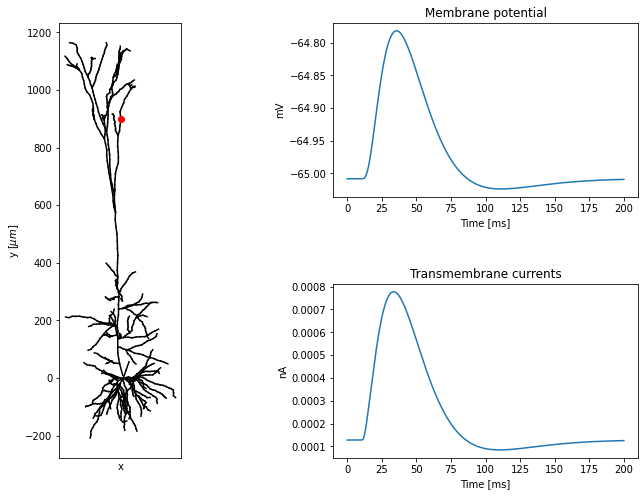

In [6]:
cell = return_cell()
plot_cell(cell)